<a href="https://colab.research.google.com/github/patil-suraj/Notebooks/blob/master/in_painting_with_stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stabel Diffusion using d🧨ffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stabel Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).


**This example is contributed by [nagolinc](https://github.com/nagolinc)!**


In [1]:
!pip install -qq -U diffusers transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 112 kB 8.8 MB/s 
     |████████████████████████████████| 4.7 MB 50.0 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 120 kB 67.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 1.6 MB 6.4 MB/s 


You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [11]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def preprocess_image(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

def preprocess_mask(mask):
    mask=mask.convert("L")
    w, h = mask.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    mask = mask.resize((w//8, h//8), resample=PIL.Image.NEAREST)
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = mask[None].transpose(0, 1, 2, 3)#what does this step do?
    mask = 1 - mask #repaint white, keep black
    mask = torch.from_numpy(mask)
    return mask


class StableDiffusionInpaintingPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        mask_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        #preprocess image
        init_image = preprocess_image(init_image).to(self.device)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)
        init_latents_orig = init_latents

        # preprocess mask
        mask = preprocess_mask(mask_image).to(self.device)
        mask = torch.cat([mask] * batch_size)

        #check sizes
        if not mask.shape == init_latents.shape:
            raise ValueError(f"The mask and init_image should be the same size!")


        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

            #masking
            init_latents_proper = self.scheduler.add_noise(init_latents_orig, noise, t)
            latents = ( init_latents_proper * mask ) + ( latents * (1-mask) )

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}


In [20]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionInpaintingPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

In [21]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

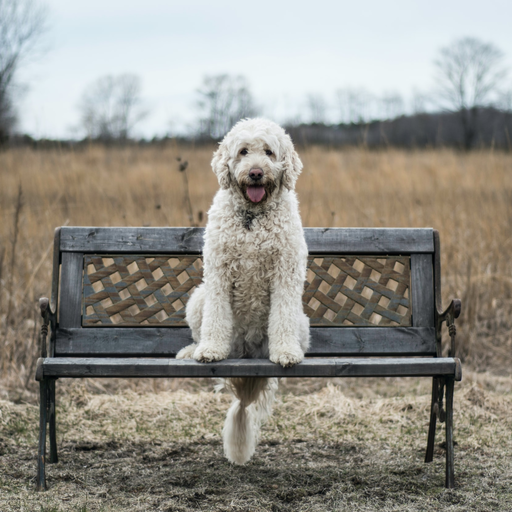

In [22]:
init_image = download_image(img_url).resize((512, 512))
init_image

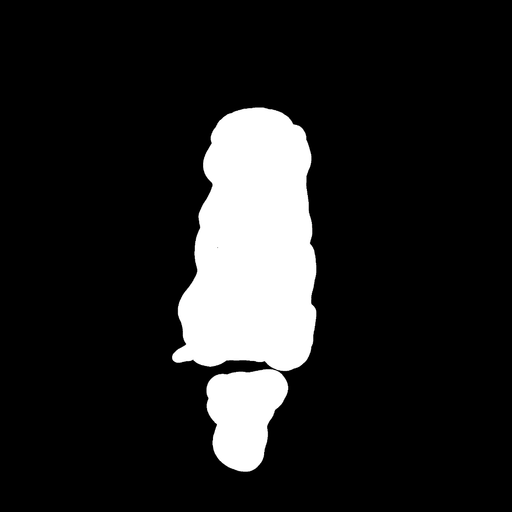

In [23]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [24]:
from torch import autocast
def inpaint(p, init_image, mask_image=None, strength=0.75, guidance_scale=7.5, generator=None, num_samples=1, n_iter=1):
    all_images = []
    for _ in range(n_iter):
        with autocast("cuda"):
            images = pipe(
                prompt=[p] * num_samples,
                init_image=init_image,
                mask_image=mask_image,
                strength=strength,
                guidance_scale=guidance_scale,
                generator=generator,
            )["sample"]
        all_images.extend(images)
    return all_images

In [28]:
p = "a cat sitting on a bench"
strength=.75
guidance_scale=7.5
num_samples = 3
n_iter = 1

generator = torch.Generator(device="cuda").manual_seed(1000) # change the seed to get different results
all_images = inpaint(p, init_image, mask_image, strength=strength, guidance_scale=guidance_scale, generator=generator, num_samples=num_samples, n_iter=n_iter)

0it [00:00, ?it/s]

In [29]:
# insert initial image in the list so we can compare side by side
all_images.insert(0, init_image)

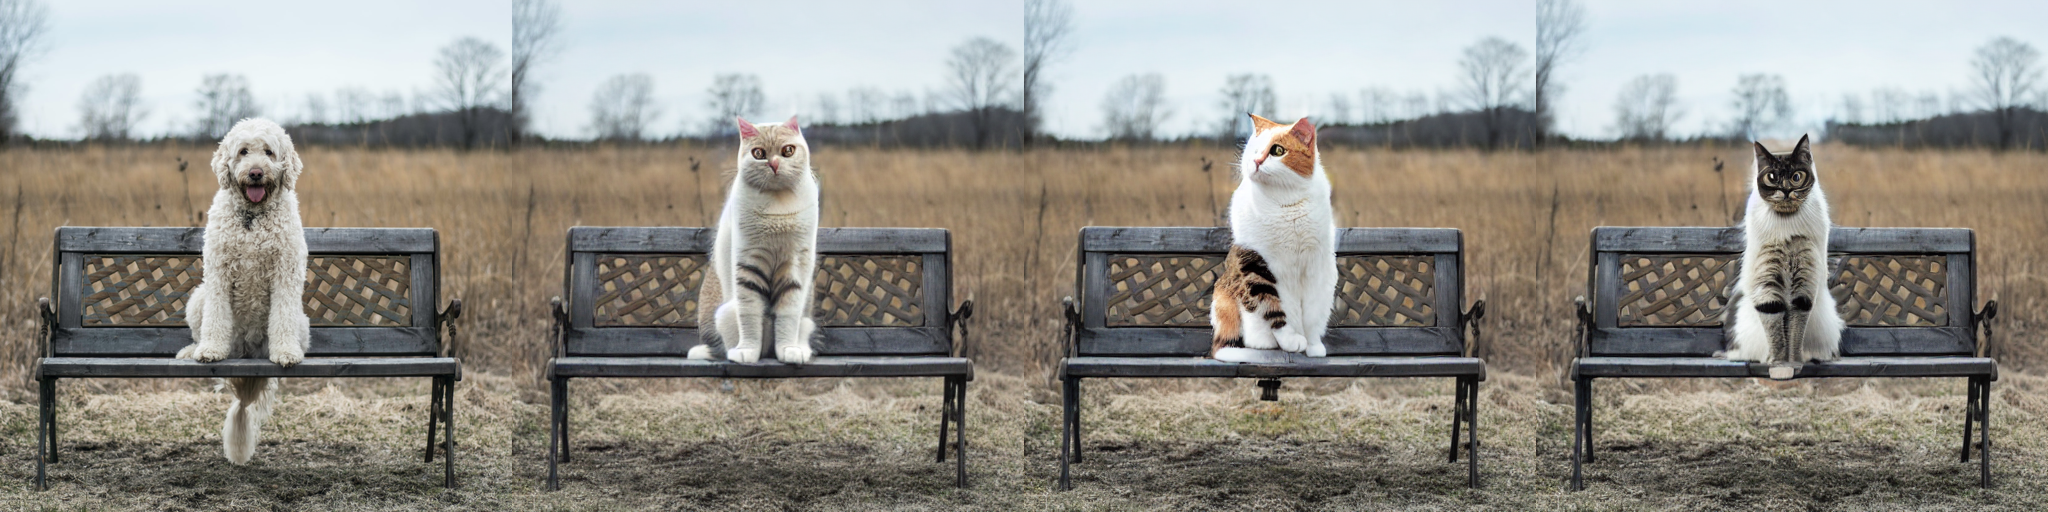

In [30]:
image_grid(all_images, n_iter, num_samples + 1)